# Two Moons

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mmd import maximum_mean_discrepancy
import two_moon_sim
import config

c:\Users\u2008181\likelihood-free\sbi_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model

This notebook will demonstrate estimations of a somewhat strange Bayesian model, whose posterior evaluated at the origin $x = (0, 0)$ of the "data" will resemble two crescent moons. The forward process is a noisy non-linear transformation on a 2D plane:

$$
\begin{align*}
x_1 &= -|\theta_1 + \theta_2|/\sqrt{2} + r \cos(\alpha) + 0.25\\
x_2 &= (-\theta_1 + \theta_2)/\sqrt{2} + r\sin{\alpha}
\end{align*}
$$

with $x = (x_1, x_2)$ playing the role of "observables" (data to be learned from), $\alpha \sim \text{Uniform}(-\pi/2, \pi/2)$, and $r \sim \text{Normal}(0.1, 0.01)$ being latent variables creating noise in the data, and $\theta = (\theta_1, \theta_2)$ being the parameters that we will later seek to infer from new $x$. We set their priors to

$$
\begin{align*}
\theta_1, \theta_2 \sim \text{Uniform}(-1, 1).
\end{align*}
$$

## Methods

We consider five methods here: NPE-C, SNPE-C, NLE, SNLE, ABC-MCMC. By fixing the total number of simulation as 5000, we compare the posterior obtained by these five methods.

In [2]:
class Approximator:
    def __init__(
        self,
        name,
        method_str,
        simulation_budget,
        seeds,
        posterior,
        MMD
    ):
        self.name = name
        self.method_name = method_str
        self.simulation_budget = simulation_budget
        self.seeds = seeds
        self.posterior = posterior
        self.MMD = MMD

In [3]:
def load_post_data(method_str, simulation_budget_str, dir_prefix=""):
    d = []
    MMD_list = []

    for i in range(len(config.seeds)):
        seed = config.seeds[i]
        post_matrix = np.loadtxt(
            f"../output/two_moons/{dir_prefix}{method_str}_post_sims{simulation_budget_str}_seed{seed}.csv",
            delimiter=",",
                                 )
        d.append(post_matrix)

        post_len = post_matrix.shape[0]
        analytic_posterior_samples = two_moon_sim.analytic_posterior_numpy(two_moon_sim.x_o_numpy, post_len)
        MMD = maximum_mean_discrepancy(
            analytic_posterior_samples,
            post_matrix,
            kernel="gaussian",
            squared=False,
        )
        MMD_list.append(float(MMD))

    return d, MMD_list

In [4]:
d, MMD_list = load_post_data("npec", "5000")
npec = Approximator(
    name="NPE-C",
    method_str="npec",
    simulation_budget=5000,
    seeds=config.seeds,
    posterior=d,
    MMD=MMD_list)

d, MMD_list = load_post_data("snpec", "5000")
snpec = Approximator(
    name="SNPE-C",
    method_str="snpec",
    simulation_budget=5000,
    seeds=config.seeds,
    posterior=d,
    MMD=MMD_list)

d, MMD_list = load_post_data("nle", "5000")
nle = Approximator(
    name="NLE",
    method_str="nle",
    simulation_budget=5000,
    seeds=config.seeds,
    posterior=d,
    MMD=MMD_list)

d, MMD_list = load_post_data("snle", "5000")
snle = Approximator(
    name="SNLE",
    method_str="snle",
    simulation_budget=5000,
    seeds=config.seeds,
    posterior=d,
    MMD=MMD_list)

d, MMD_list = load_post_data("abc_mcmc", "5000")
abc_mcmc = Approximator(
    name="ABC-MCMC",
    method_str="abc_mcmc",
    simulation_budget=5000,
    seeds=config.seeds,
    posterior=d,
    MMD=MMD_list)

approximator_list = [npec, snpec, nle, snle, abc_mcmc]

### Posterior scatterplot

In [5]:
# function to plot posterior samples
def plot_posteriors(approximator_list, num_post=0):
    subplot_num = len(approximator_list)
    fig, axes = plt.subplots(1, subplot_num, figsize=(20, 4), sharey=True)

    for i, ax in enumerate(axes):
        data = approximator_list[i].posterior[num_post]

        ax.scatter(data[:, 0], data[:, 1], alpha=0.5, s=10)

        ax.set_title(approximator_list[i].name)
        ax.set_xlabel("X")
        if i == 0:
            ax.set_ylabel("Y") # Only label the first Y axis to save space
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_xlim([-0.5, 0.5])
        ax.set_ylim([-0.5, 0.5])

    plt.tight_layout() # Prevents labels from overlapping
    plt.show()

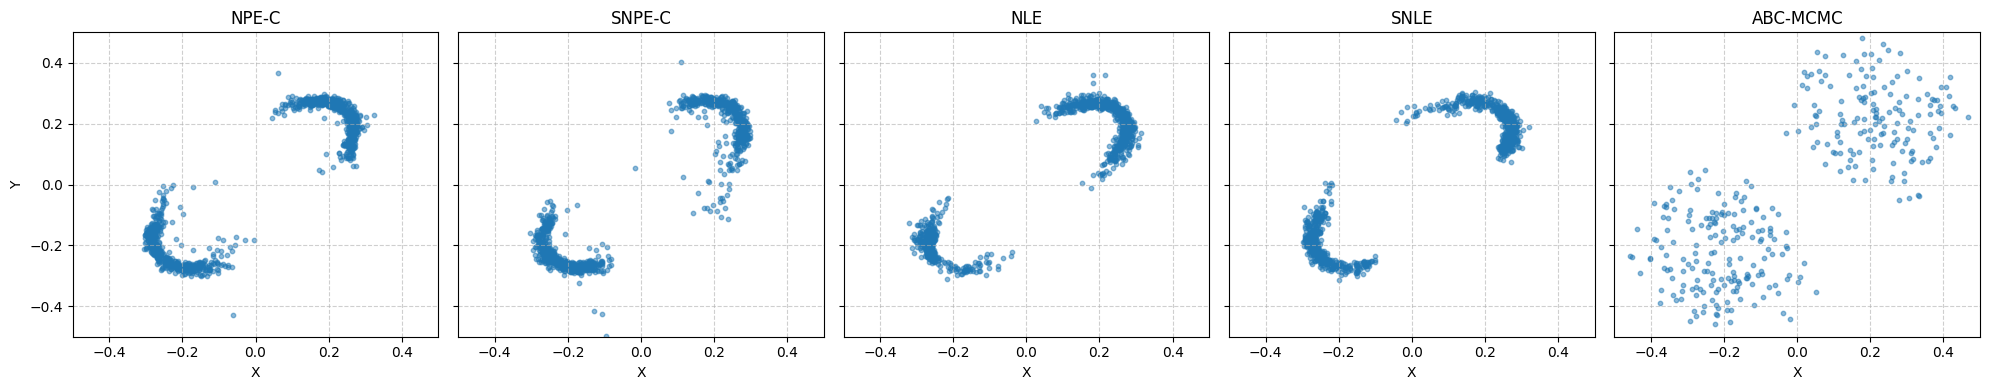

In [ ]:
plot_posteriors(approximator_list, num_post=1) # num_post=6 shows wrong posterior

### Posterior MMD

In [7]:
# function to compare MMD
def plot_mmd_comparison(approximator_list):
    mmd_plot = [approximator.MMD for approximator in approximator_list]

    plt.figure(figsize=(6, 4))
    sns.boxplot(
        data=mmd_plot,
        width=0.6,
        flierprops={"marker": "o"},
        boxprops={"facecolor": (0.0, 0, 0.53, 0.3)},
        linewidth=2
    )

    plt.xticks(
        ticks=range(len(approximator_list)),
        labels=[approximator.name for approximator in approximator_list],
        rotation=90
    )
    plt.title("Posterior maximum mean discrepancy")
    plt.ylabel("MMD")

    plt.show()

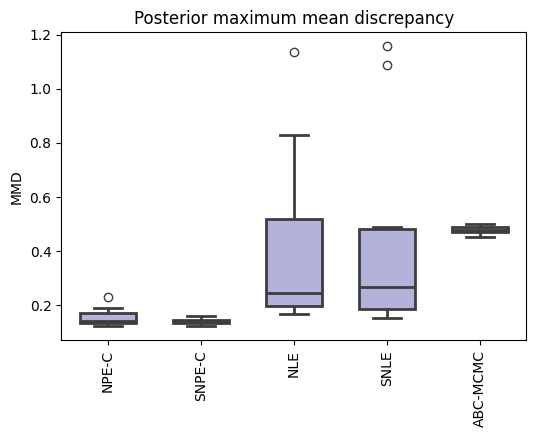

In [8]:
plot_mmd_comparison(approximator_list)